# exp41

lag_diffのcatboost


https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import lightgbm as lgb
import xgboost as xgb


In [2]:

# ====================================================
# Get the difference
# ====================================================
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet('/content/data/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    test = pd.read_parquet('../input/amex-fe/test_fe.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    train.to_parquet('../input/amex-fe/train_fe.parquet')
    test.to_parquet('../input/amex-fe/test_fe.parquet')

# Read & Preprocess Data
read_preprocess_data()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.parquet'

# Training & Inference

In [3]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

import pickle

# ====================================================
# Configurations
# ====================================================
class CFG:
    
    
    # input_dir = '../feature/exp35_lagdiff/'
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp47_optuna/'
    seed = 42
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "cat"
    ver = "exp47"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
# def read_data():
#     train = pd.read_parquet(CFG.input_dir + 'train_diff.parquet')
#     test = pd.read_parquet(CFG.input_dir + 'test_diff.parquet')
#     return train, test

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True


In [4]:
seed_everything(CFG.seed)

train = pd.read_parquet('../feature/exp38_lagdiff_c3/train_lagdiff_c3.parquet')
test = pd.read_parquet('../feature/exp38_lagdiff_c3/test_lagdiff_c3.parquet')

# train = pd.read_parquet('../feature/exp35_lagdiff/train_lagdiff.parquet')
# test = pd.read_parquet('../feature/exp35_lagdiff/test_lagdiff.parquet')

# # train, test = read_data()

# train_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/train_c3.pkl')
# test_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/test_c3.pkl')

# train = train.merge(train_c3,on = "customer_ID",how = "left")
# test = test.merge(test_c3,on = "customer_ID",how = "left")

# del train_c3,test_c3
# gc.collect

# print(train.shape)
# print(test.shape)

In [5]:

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def cat_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

In [6]:

from catboost import CatBoostClassifier

def objective(trial):
    # {'depth': 10, 'min_child': 13, 'rate': 0.052641561760702615}
    # depth = trial.suggest_int("depth", 10, 10)
    # min_child = trial.suggest_int("min_child", 12, 13)
    rate = trial.suggest_float("rate", 0.0001, 0.05)

    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68"
    ]

    # kmeans_list = ["kmeans pred 2","kmeans pred 3","kmeans pred 4"]

    cat_features = [f"{cf}_last" for cf in cat_features]
    # cat_features.extend(kmeans_list)

    # for cat_col in cat_features:
    # #     print(cat_col)
    #     encoder = LabelEncoder()
    #     train[cat_col] = encoder.fit_transform(train[cat_col])
    #     test[cat_col] = encoder.transform(test[cat_col])


    features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]


    prams = {
        'depth': 10,
        'iterations':9999,#9999
        'learning_rate': 0.02,
        'random_state':CFG.seed,
        'task_type':"CPU",
        'learning_rate':rate,
        'min_child_samples':13,
        'early_stopping_rounds': 300,
        # 'custom_metric' : 'cat_amex'
    }

    # Create a numpy array to store test predictions
    test_predictions = np.zeros(len(test))
    # Create a numpy array to store out of folds predictions
    oof_predictions = []

    cids = []
    tr_target = []

    # epoch = [10000,7500,7500,8500,10500]

    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        
        if fold == 1:
            break
            
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        
        
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]

        model = CatBoostClassifier(**prams)
    
        model.fit(x_train, y_train,
                  eval_set = [(x_val, y_val)], 
                  metric_period=100,
                  # eval_metrics = cat_amex
                 )

        # Save best model
        # model.save_model(f'{CFG.output_dir}{CFG.model}_{CFG.ver}_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.xgb')
    #     joblib.dump(model, f'{CFG.output_dir}lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict_proba(x_val)[:,1]
        # Add to out of folds array
        oof_predictions.extend(val_pred)
        cids.extend(train["customer_ID"].loc[val_ind])
        tr_target.extend(train["target"].loc[val_ind])

        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val
        gc.collect()

    # Compute out of folds metric
    # score = amex_metric(train[CFG.target], oof_predictions)
    # print(f'Our out of folds CV score is {score}')

    return 1 - score


In [7]:
import optuna

study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=5)

[I 2022-08-07 10:45:11,223] A new study created in memory with name: no-name-9dd2c12c-b797-4ac7-9e68-f0f00bcb6728


 
--------------------------------------------------
Training fold 0 with 2011 features...


0:	learn: 0.6674994	test: 0.6674338	best: 0.6674338 (0)	total: 3.36s	remaining: 9h 19m 30s
100:	learn: 0.2393860	test: 0.2414169	best: 0.2414169 (100)	total: 5m 29s	remaining: 8h 57m 56s
200:	learn: 0.2230588	test: 0.2280321	best: 0.2280321 (200)	total: 10m 56s	remaining: 8h 53m 40s
300:	learn: 0.2157886	test: 0.2238421	best: 0.2238421 (300)	total: 16m 27s	remaining: 8h 50m 5s
400:	learn: 0.2103440	test: 0.2216153	best: 0.2216153 (400)	total: 21m 52s	remaining: 8h 43m 40s
500:	learn: 0.2058733	test: 0.2201787	best: 0.2201787 (500)	total: 27m 17s	remaining: 8h 37m 24s


KeyboardInterrupt: 

In [ ]:

# from catboost import CatBoostClassifier

# cat_features = [
#     "B_30",
#     "B_38",
#     "D_114",
#     "D_116",
#     "D_117",
#     "D_120",
#     "D_126",
#     "D_63",
#     "D_64",
#     "D_66",
#     "D_68"
# ]

# # kmeans_list = ["kmeans pred 2","kmeans pred 3","kmeans pred 4"]

# cat_features = [f"{cf}_last" for cf in cat_features]
# # cat_features.extend(kmeans_list)

# for cat_col in cat_features:
# #     print(cat_col)
#     encoder = LabelEncoder()
#     train[cat_col] = encoder.fit_transform(train[cat_col])
#     test[cat_col] = encoder.transform(test[cat_col])


# features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

# prams = {
#     'depth': 8,
#     'iterations':9999,#9999
#     'learning_rate': 0.02,
#     'random_state':CFG.seed,
#     'task_type':"CPU",
#     'early_stopping_rounds': 300,
#     # 'custom_metric' : 'cat_amex'
# }

# # Create a numpy array to store test predictions
# test_predictions = np.zeros(len(test))
# # Create a numpy array to store out of folds predictions
# oof_predictions = []

# cids = []
# tr_target = []

# kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
# for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
#     print(' ')
#     print('-'*50)
#     print(f'Training fold {fold} with {len(features)} features...')
#     x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
#     y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
# #     lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
# #     lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
    
# #     des = DartEarlyStopping("valid_1", CFG.metric, 1000)
    
#     model = CatBoostClassifier(**prams)
    
#     model.fit(x_train, y_train,
#                   eval_set = [(x_val, y_val)], 
#                   metric_period=100
#                  )
    
# #     model = lgb.train(
# #         params = params,
# #         train_set = lgb_train,
# #         num_boost_round = epoch[fold],#10500
# #         valid_sets = [lgb_train, lgb_valid],
# #         early_stopping_rounds = 1500,
# # #         eval_metric=[lgb_amex_metric],
# #         verbose_eval = 500,
# #         feval = lgb_amex_metric
# #         )
    
#     # Save best model
#     model.save_model(f"{CFG.output_dir}{CFG.model}_fold{fold}_seed{CFG.seed}.cbm")
#     joblib.dump(model, f'{CFG.output_dir}lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
#     # Predict validation
    
#     val_pred = model.predict_proba(x_val)[:,1]
#     oof_predictions.extend(val_pred)
    
    
#     cids.extend(train["customer_ID"].loc[val_ind])
#     tr_target.extend(train["target"].loc[val_ind])
    
#     # Predict the test set
#     test_pred = model.predict_proba(test[features])[:,1]
#     # test_pred = model.predict(test[features])
#     test_predictions += test_pred / CFG.n_folds
#     # Compute fold metric
    
#     score = amex_metric(y_val, val_pred)
#     print(f'Our fold {fold} CV score is {score}')
#     del x_train, x_val, y_train, y_val
#     gc.collect()
    
# # Compute out of folds metric
# score = amex_metric(tr_target, oof_predictions)
# print(f'Our out of folds CV score is {score}')


# # Create a dataframe to store test prediction
# test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# # test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# dic_oof = {
#     "customer_ID":cids,
#     "target":tr_target,
#     f"{CFG.ver}_{CFG.model}_oof":oof_predictions
# }

# # Create a dataframe to store out of folds predictions
# oof_df = pd.DataFrame(dic_oof)
# # oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
# oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # # Create a dataframe to store out of folds predictions
# # oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
# # oof_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/oof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # # Create a dataframe to store test prediction
# # test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# # test_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/test_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


<AxesSubplot:>

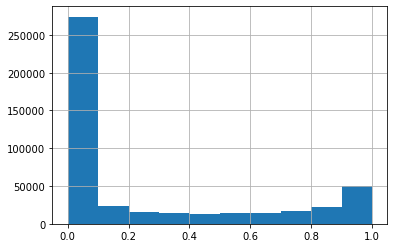

In [7]:
oof_df[f"{CFG.ver}_{CFG.model}_oof"].hist()

In [19]:
len(oof_df)

458913